In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib.ticker import MultipleLocator

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

from matplotlib.colors import LinearSegmentedColormap
colour_list = ["#c8274c","#f25546","#F06543","#e96e33",
               "#f0b038","#FFE74C","#69b944","#72b286",
               "#69b0bc","#619ee4","#4b5bbb"][::-1]
cmapIAM = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

# Functions

In [2]:
def get_vars(dirname, x_ind, t_end, flag):

    fname = "1_MCKNZ_1h_20170101_201701*"
    y = slice(1,-1,None)

    if flag == 'U':
        files = general_functions.get_files(dirname, fname, 'grid_U')
        varname = 'vozocrtx'
        maskname = 'umask'
    
    elif flag == 'V':
        files = general_functions.get_files(dirname, fname, 'grid_V')
        varname = 'vomecrty'
        maskname = 'vmask'
    
    elif flag == 'W':
        files = general_functions.get_files(dirname, fname, 'grid_W')
        varname = 'vovecrtz'
        maskname = 'tmask'
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U')
    with scDataset(filesU) as dsU:
        sozotaux = dsU.variables['sozotaux'][:t_end,0,0]

    with scDataset(files) as ds:
        vel0 = ds.variables[varname][:t_end,:,y,x_ind]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
            mask0 = dsM.variables[maskname][0,:,y,x_ind]

    mask = np.tile(mask0, (len(sozotaux), 1, 1))

    vel = np.ma.array(vel0, mask=1 - mask)

    return vel

In [3]:
def get_mask(dirname):
    y, x = slice(1,-1,None), slice(1,-1,None)
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
            tmask = dsM.variables['tmask'][0,:,y,x]
            gdept = dsM.variables['gdept_1d'][0, :]
    return tmask, gdept

# x_ind's

In [4]:
x_indA, x_indB, x_indC, x_indD = 170, 190, 210, 230
t_end = 4*24

In [5]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/initial_collection/ideal_base_muscl_partial/'

# Mask and x_ind's

In [6]:
tmask, gdept = get_mask(dirname)

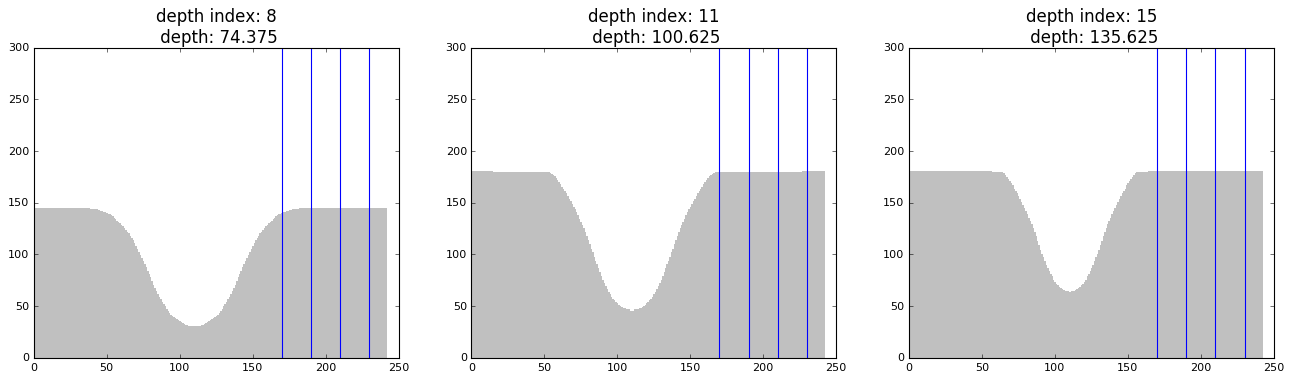

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ax, dep in zip(axes.flatten(), [8, 11, 15]):
    cmap_land = LinearSegmentedColormap.from_list('mycmap', ['silver', 'white'])
    ax.pcolormesh(tmask[dep, :, :], cmap=cmap_land)
    ax.set_title('depth index: '+str(dep)+'\n depth: '+str(gdept[dep]), fontsize=15)
    ax.axvline(x_indA)
    ax.axvline(x_indB)
    ax.axvline(x_indC)
    ax.axvline(x_indD)

# Animation Functions

In [105]:
def calculate_speed(U_vel, V_vel):
    speed = np.sqrt(U_vel**2 + V_vel**2)
    return speed

In [35]:
def init():
    for ax, title in zip(axes.flatten(), ['A', 'B', 'C', 'D']):
        ax.set_title(title, fontsize=20)
    return

In [90]:
def animate(time_ind):
    for ax, this_vel in zip(axes.flatten(), X_vel_all):
        ax.cla()
        p = ax.pcolormesh(this_vel[time_ind, :, :], cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xlim([0, this_vel.shape[-1]])
        ax.set_ylim([this_vel.shape[-2], 0])
        plt.suptitle('Hour: '+str(time_ind), fontsize=22)
        if time_ind == 0:
            plt.colorbar(p, ax=ax, orientation='horizontal', pad=0.05)
        else:
            pass
    return p,

# U Velocity

In [103]:
U_velA = get_vars(dirname, x_indA, t_end, 'U')
U_velB = get_vars(dirname, x_indB, t_end, 'U')
U_velC = get_vars(dirname, x_indC, t_end, 'U')
U_velD = get_vars(dirname, x_indD, t_end, 'U')

X_vel_all = [U_velA, U_velB, U_velC, U_velD]

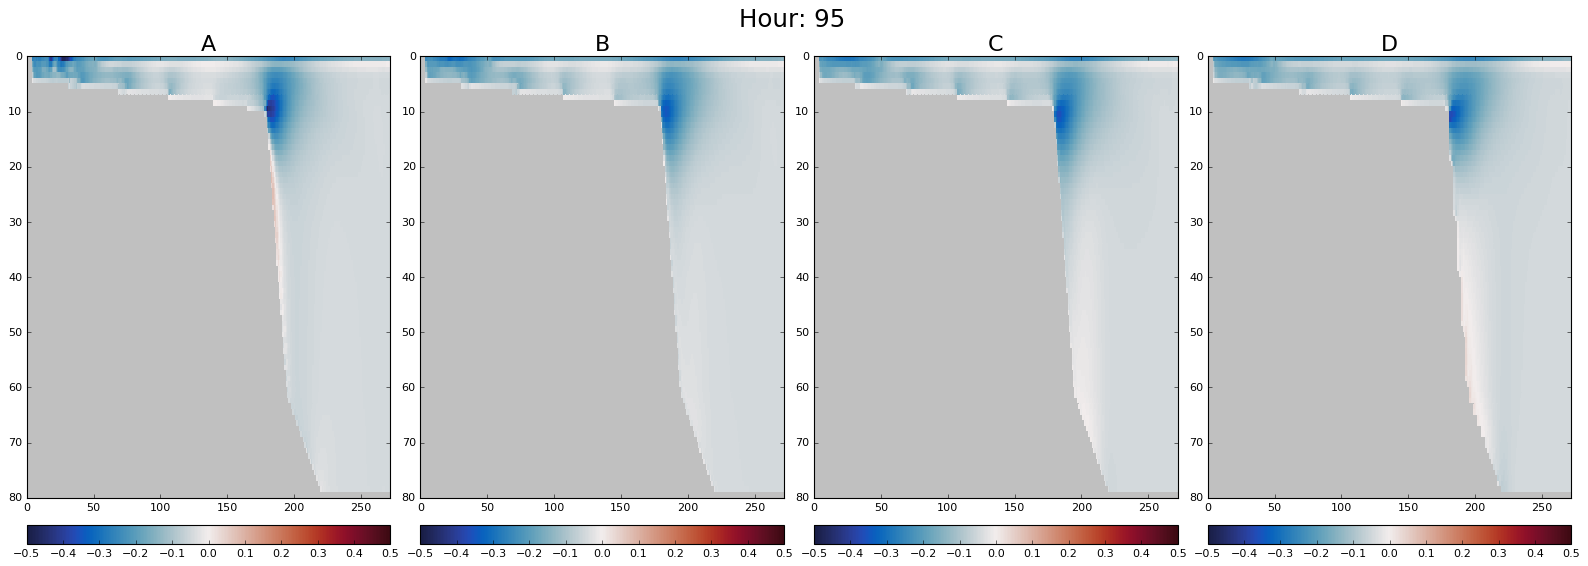

In [104]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
fig.tight_layout(w_pad=0.025)
fig.tight_layout(rect=[0, 0, 1, 0.93])
cmap = cmo.cm.balance
cmap.set_bad('silver')
vmin, vmax = -0.5, 0.5

Writer = animation.writers['ffmpeg']
writer = Writer(fps=4, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=4*24)
anim.save('incoming_slope_U.mp4', writer=writer)

# V Velocity

In [95]:
V_velA = get_vars(dirname, x_indA, t_end, 'V')
V_velB = get_vars(dirname, x_indB, t_end, 'V')
V_velC = get_vars(dirname, x_indC, t_end, 'V')
V_velD = get_vars(dirname, x_indD, t_end, 'V')

X_vel_all = [V_velA, V_velB, V_velC, V_velD]

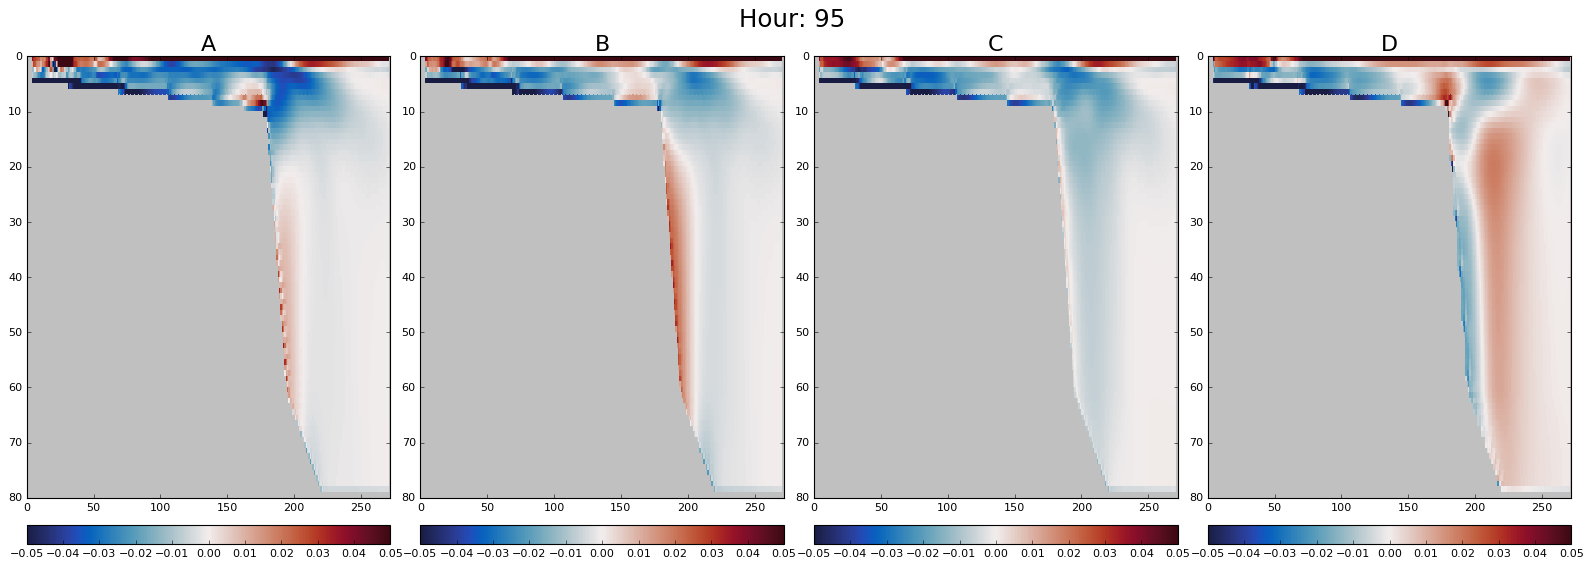

In [101]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
fig.tight_layout(w_pad=0.025)
fig.tight_layout(rect=[0, 0, 1, 0.93])
cmap = cmo.cm.balance
cmap.set_bad('silver')
vmin, vmax = -0.05, 0.05

Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=4*24)
anim.save('incoming_slope_V.mp4', writer=writer)

# W Velocity

In [74]:
W_velA = get_vars(dirname, x_indA, t_end, 'W')
W_velB = get_vars(dirname, x_indB, t_end, 'W')
W_velC = get_vars(dirname, x_indC, t_end, 'W')
W_velD = get_vars(dirname, x_indD, t_end, 'W')

X_vel_all = [W_velA, W_velB, W_velC, W_velD]

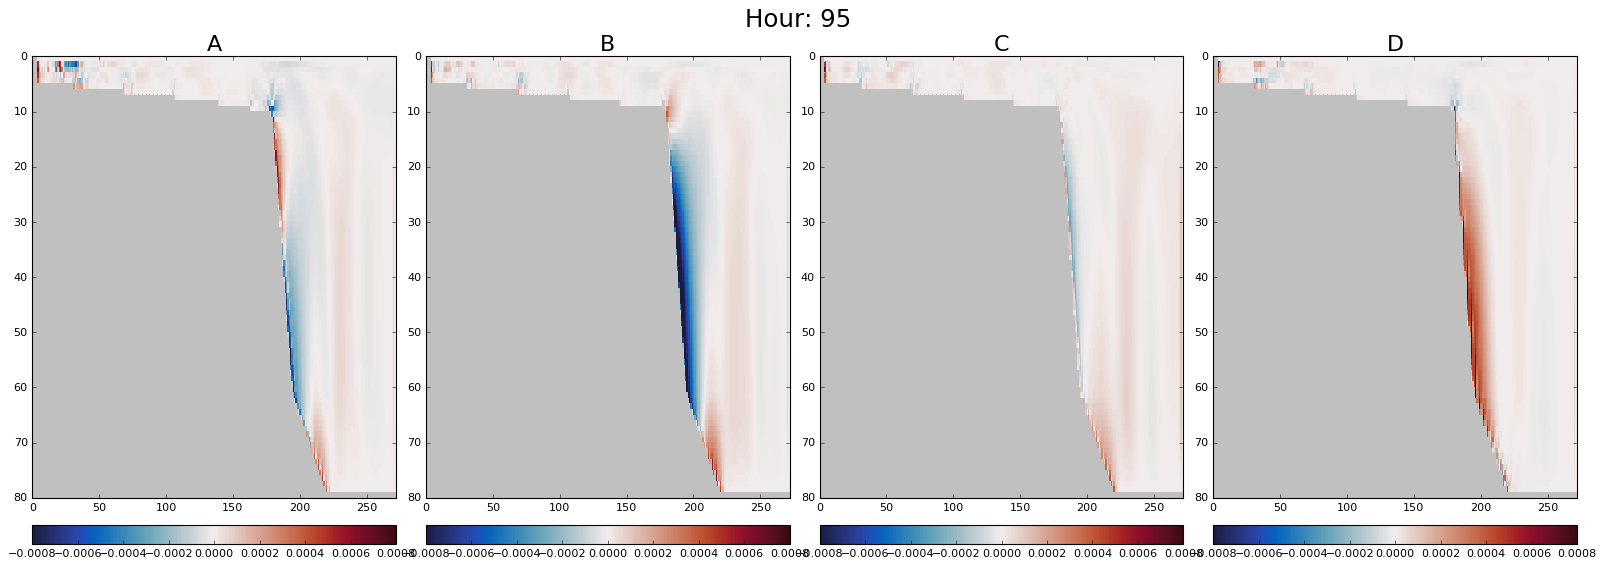

In [94]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
fig.tight_layout(w_pad=0.025)
fig.tight_layout(rect=[0, 0, 1, 0.93])
cmap = cmo.cm.balance
cmap.set_bad('silver')
vmin, vmax = -0.0008, 0.0008

Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=4*24)
anim.save('incoming_slope_W.mp4', writer=writer)

# Speeds

In [111]:
speedsA = calculate_speed(U_velA, V_velA)
speedsB = calculate_speed(U_velB, V_velB)
speedsC = calculate_speed(U_velC, V_velC)
speedsD = calculate_speed(U_velD, V_velD)

X_vel_all = [speedsA, speedsB, speedsC, speedsD]

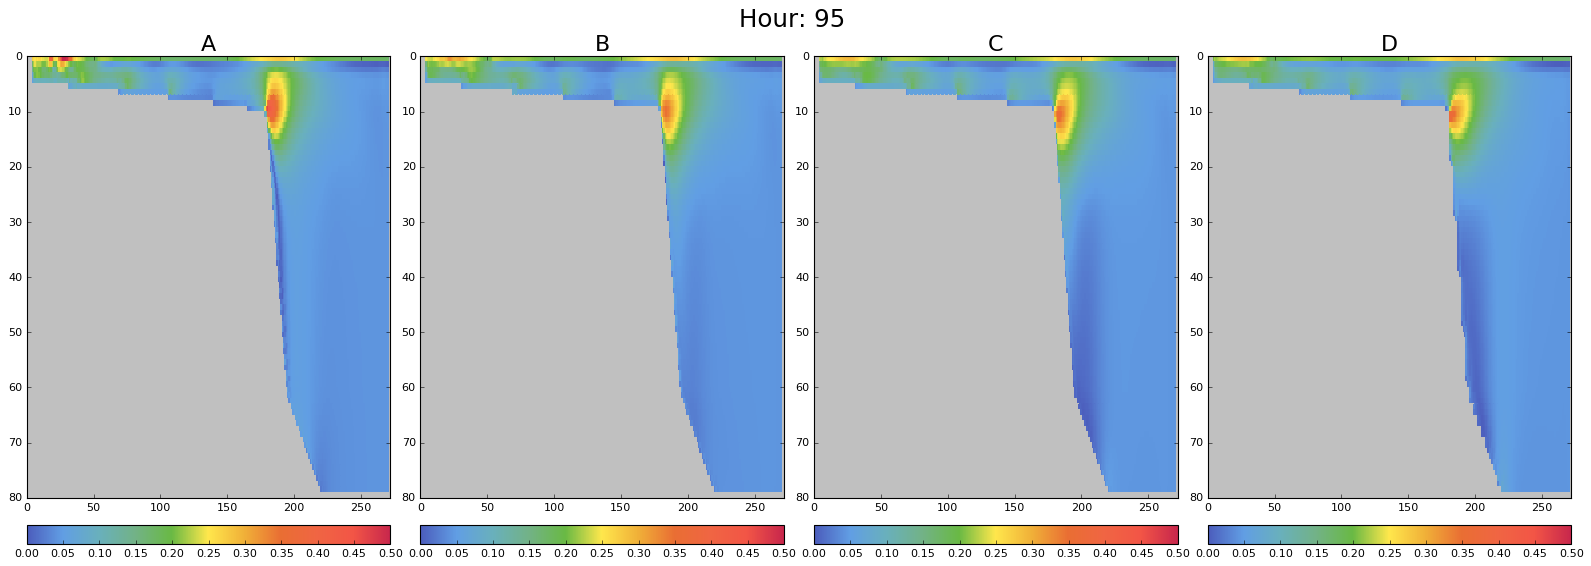

In [116]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharey=True)
fig.tight_layout(w_pad=0.025)
fig.tight_layout(rect=[0, 0, 1, 0.93])
cmap = cmapIAM
cmap.set_bad('silver')
vmin, vmax = 0, 0.5

Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=4*24)
anim.save('incoming_slope_speeds.mp4', writer=writer)